# Synthetic Control for the Purchase of Twitter

`Objective`: Use the Synthetic Control method to effectively demonstrate the impact of Elon Musk purchasing Twitter on overall sentiment towards the company and on Twitter's stock price.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import csv
import snscrape.modules.twitter as sntwitter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
pd.set_option('display.max_colwidth', None)

## Loading Tweets
- Tweets with 'Twitter' keyword will represent Real Twitter Sentiment
- Tweets with other keywords (Facebook, Snapchat, etc.) will combine to form Synthetic Twitter Sentiment

In [2]:
# Elon Musk buys twitter 04/25/2022 at 3pm
# Start and end date are 1 day apart because we want a certain number of tweets per day
start_date = '2022-04-18'
end_date = '2022-04-19'

In [84]:
# https://medium.datadriveninvestor.com/how-to-build-a-twitter-scraping-app-with-python-b3fc069a19c6

# Initialize keywords
keywords = ['Twitter', 'Facebook', 'Instagram', 'LinkedIn', 'Snapchat', 'Reddit']
maxTweets = 2000

# Iterate over all days one at a time
for i in range(12):
    start_date = dt.datetime.strftime(dt.datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
    end_date = dt.datetime.strftime(dt.datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
    
    # Iterate over chosen keywords
    for keyword in keywords:
        # Open/create a file to append data to
        csvFile = open(keyword + '_' + start_date + '.csv', 'a', newline='', encoding='utf8')
        csvFile.truncate(0)
        csvWriter = csv.writer(csvFile)

        # Initialize scraper object
        scraper = sntwitter.TwitterSearchScraper(keyword + ' lang:en since:' +  start_date + ' until:' + end_date)

        # Iterate over tweet info and write to csv
        for i, tweet in enumerate(scraper.get_items()):
            if i >= maxTweets :
                break
            csvWriter.writerow([tweet.id, tweet.date, tweet.user, tweet.content, tweet.likeCount,
                                tweet.retweetCount, tweet.quoteCount, tweet.replyCount])
        csvFile.close()

In [84]:
# List of dates and keywords needed for import
keywords = ['Twitter', 'Facebook', 'Instagram', 'LinkedIn', 'Snapchat', 'Reddit']
dates = ['2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25', '2022-04-26', 
        '2022-04-27', '2022-04-28', '2022-04-29', '2022-04-30']

In [85]:
# Load all CSVs into one df 
df = pd.DataFrame()
for keyword in keywords:
    for date in dates:
        df1 = pd.read_csv(keyword + '_' + date + '.csv', header=None).assign(company=keyword)
        df = pd.concat([df, df1])
df.reset_index(drop=True, inplace=True)
df.columns = ['id', 'date', 'user', 'content', 'likes', 'retweets', 'quotes', 'replies', 'company']
print(df.shape)
df.head()

(144000, 9)


,id,date,user,content,likes,retweets,quotes,replies,company
0,1516567316531748866,2022-04-19 23:59:59+00:00,https://twitter.com/Jazzboneplyr1,@Alex343 @eb454 @paulkrugman @Twitter we were speaking about harassment of people wearing masks,1,0,0,2,Twitter
1,1516567316292644864,2022-04-19 23:59:59+00:00,https://twitter.com/SandaraMary,@mhdksafa @Twitter Support your views!,0,0,0,0,Twitter
2,1516567316204560389,2022-04-19 23:59:59+00:00,https://twitter.com/ppotagonist,Incredibly important tweet for those of you who thrive on tearing apart who you identify as “twitter main character of the day” \n\nStop 🛑 https://t.co/2Awn7NPBsk,0,0,0,1,Twitter
3,1516567315957133317,2022-04-19 23:59:59+00:00,https://twitter.com/RayTesla_,@Brian07li @sloppytopgiver @defaultgunner @raptalksk @AnfieldAn The whole white ppl in hip hop thing is such a bs thing &amp; it ONLY exists on Twitter. Hip hop is inclusive. Everybody is welcomed. Just respect the craft,0,0,0,1,Twitter
4,1516567311817318406,2022-04-19 23:59:58+00:00,https://twitter.com/Kasperinos,what’s up twitter,17,0,0,3,Twitter


In [86]:
# Check number of tweets per company
df.company.value_counts()

Twitter      24000
Facebook     24000
Instagram    24000
LinkedIn     24000
Snapchat     24000
Reddit       24000
Name: company, dtype: int64

## Calculating Sentiment Scores using VaderSentiment
- These scores represent the attitude of the tweet
- The Compound Scores will be used as the values for Synthetic Control

In [87]:
# Calculate sentiment scores and create list of dictionaries
analyser = SentimentIntensityAnalyzer()
scores = [analyser.polarity_scores(tweet) for tweet in df['content']]
scores[0:5]

[{'neg': 0.226, 'neu': 0.774, 'pos': 0.0, 'compound': -0.5423},
 {'neg': 0.0, 'neu': 0.572, 'pos': 0.428, 'compound': 0.4574},
 {'neg': 0.149, 'neu': 0.78, 'pos': 0.071, 'compound': -0.3197},
 {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'compound': 0.6705},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [88]:
# Add sentiment scores for each tweet to the df
df = pd.concat([df, pd.DataFrame(scores)], axis=1)
df.head()

,id,date,user,content,likes,retweets,quotes,replies,company,neg,neu,pos,compound
0,1516567316531748866,2022-04-19 23:59:59+00:00,https://twitter.com/Jazzboneplyr1,@Alex343 @eb454 @paulkrugman @Twitter we were speaking about harassment of people wearing masks,1,0,0,2,Twitter,0.226,0.774,0.000,-0.5423
1,1516567316292644864,2022-04-19 23:59:59+00:00,https://twitter.com/SandaraMary,@mhdksafa @Twitter Support your views!,0,0,0,0,Twitter,0.000,0.572,0.428,0.4574
2,1516567316204560389,2022-04-19 23:59:59+00:00,https://twitter.com/ppotagonist,Incredibly important tweet for those of you who thrive on tearing apart who you identify as “twitter main character of the day” \n\nStop 🛑 https://t.co/2Awn7NPBsk,0,0,0,1,Twitter,0.149,0.780,0.071,-0.3197
3,1516567315957133317,2022-04-19 23:59:59+00:00,https://twitter.com/RayTesla_,@Brian07li @sloppytopgiver @defaultgunner @raptalksk @AnfieldAn The whole white ppl in hip hop thing is such a bs thing &amp; it ONLY exists on Twitter. Hip hop is inclusive. Everybody is welcomed. Just respect the craft,0,0,0,1,Twitter,0.000,0.857,0.143,0.6705
4,1516567311817318406,2022-04-19 23:59:58+00:00,https://twitter.com/Kasperinos,what’s up twitter,17,0,0,3,Twitter,0.000,1.000,0.000,0.0000


## Structuring Data for "By-Hand" Synthetic Control
- Creating Synthetic Twitter Sentiment by simply taking the average Compound Sentiment Scores of all the other companies combined
- This is a simpler version of Synthetic Control to use as a baseline

In [89]:
# Strip date column into correct string format
df['Date'] = [date[0:10] for date in df['date']]
df.head()

,id,date,user,content,likes,retweets,quotes,replies,company,neg,neu,pos,compound,Date
0,1516567316531748866,2022-04-19 23:59:59+00:00,https://twitter.com/Jazzboneplyr1,@Alex343 @eb454 @paulkrugman @Twitter we were speaking about harassment of people wearing masks,1,0,0,2,Twitter,0.226,0.774,0.000,-0.5423,2022-04-19
1,1516567316292644864,2022-04-19 23:59:59+00:00,https://twitter.com/SandaraMary,@mhdksafa @Twitter Support your views!,0,0,0,0,Twitter,0.000,0.572,0.428,0.4574,2022-04-19
2,1516567316204560389,2022-04-19 23:59:59+00:00,https://twitter.com/ppotagonist,Incredibly important tweet for those of you who thrive on tearing apart who you identify as “twitter main character of the day” \n\nStop 🛑 https://t.co/2Awn7NPBsk,0,0,0,1,Twitter,0.149,0.780,0.071,-0.3197,2022-04-19
3,1516567315957133317,2022-04-19 23:59:59+00:00,https://twitter.com/RayTesla_,@Brian07li @sloppytopgiver @defaultgunner @raptalksk @AnfieldAn The whole white ppl in hip hop thing is such a bs thing &amp; it ONLY exists on Twitter. Hip hop is inclusive. Everybody is welcomed. Just respect the craft,0,0,0,1,Twitter,0.000,0.857,0.143,0.6705,2022-04-19
4,1516567311817318406,2022-04-19 23:59:58+00:00,https://twitter.com/Kasperinos,what’s up twitter,17,0,0,3,Twitter,0.000,1.000,0.000,0.0000,2022-04-19


In [90]:
# Group by company and date and aggregate sentiment scores
comp_date_scores = df.groupby(['company', 'Date'])[['neg', 'pos', 'neu', 'compound']].mean()
# Segment just Twitter
twitter = comp_date_scores.loc['Twitter']
twitter

,neg,pos,neu,compound
Date,,,,
2022-04-19,0.077192,0.116656,0.806155,0.124487
2022-04-20,0.078219,0.118613,0.803159,0.115027
2022-04-21,0.080174,0.115527,0.804297,0.110883
2022-04-22,0.081254,0.114841,0.803901,0.105457
2022-04-23,0.086941,0.121575,0.791491,0.099592
2022-04-24,0.081282,0.114417,0.804308,0.094618
2022-04-25,0.068813,0.119156,0.812038,0.140242
2022-04-26,0.075836,0.116013,0.808158,0.117697
2022-04-27,0.076698,0.118579,0.804717,0.123595


In [91]:
# Segment other companies
others = comp_date_scores.loc[['Facebook', 'Instagram', 'LinkedIn', 'Snapchat', 'Reddit']]

In [92]:
# Group others by date and aggregate sentiment scores
others_combined = others.groupby('Date')[['neg', 'pos', 'neu', 'compound']].mean()
others_combined

,neg,pos,neu,compound
Date,,,,
2022-04-19,0.067979,0.103167,0.828855,0.114296
2022-04-20,0.066546,0.121766,0.811692,0.118524
2022-04-21,0.067966,0.102867,0.829169,0.106310
2022-04-22,0.068818,0.104069,0.827115,0.110661
2022-04-23,0.068436,0.103673,0.827889,0.106546
2022-04-24,0.065002,0.106860,0.828143,0.124492
2022-04-25,0.066829,0.103137,0.830031,0.105216
2022-04-26,0.067345,0.106500,0.826155,0.119198
2022-04-27,0.066682,0.101273,0.832049,0.114871


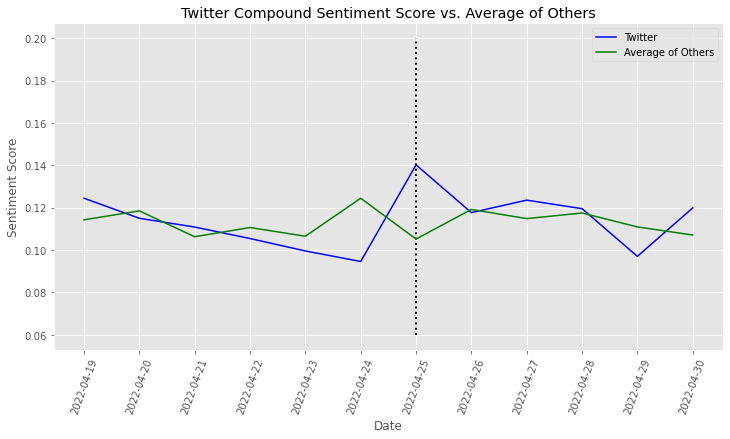

In [93]:
# "By-hand" Synthetic Control using mean of Twitter vs mean of others combined
plt.figure(figsize=(12,6))
sns.lineplot(data=twitter, x='Date', y='compound', color='blue', label='Twitter')
sns.lineplot(data=others_combined, x='Date', y='compound', color='green', label='Average of Others')
plt.vlines(x='2022-04-25', ymin=.06, ymax=.20, linestyle=":", lw=2, label='Elon Musk Buys Twitter', color='black')
plt.title('Twitter Compound Sentiment Score vs. Average of Others')
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=70);
plt.show();

Not a great representation of the impact, but we can at least see the Synthetic and Real Twitter following each other somewhat closely pre-purchase.  The goal is to see the Real and Synthetic follow each other closely pre-purchase, and then diverge after the purchase.

## Synthetic Control for Compound Sentiment Score (Round 1)
- Synthetic Twitter created using Linear Regression to calculate weights for each company
- The Synthetic sentiment score (combination of all others) will be plotted against the sentiment for only Twitter

In [94]:
# reset index and create new df
df3 = comp_date_scores.reset_index()
# Construct day column
df3['Day'] = [date[8:10] for date in df3['Date']]
df3['Day'] = df3['Day'].astype(int)
# Add boolean column for Twitter or not
df3['Twitter'] = np.where(df3['company'] == 'Twitter', True, False)
df3

,company,Date,neg,pos,neu,compound,Day,Twitter
0,Facebook,2022-04-19,0.074993,0.101807,0.823210,0.109483,19,False
1,Facebook,2022-04-20,0.071859,0.099841,0.828300,0.104920,20,False
2,Facebook,2022-04-21,0.070761,0.105739,0.823495,0.117222,21,False
3,Facebook,2022-04-22,0.069179,0.107949,0.822871,0.123297,22,False
4,Facebook,2022-04-23,0.068549,0.107415,0.824033,0.127343,23,False
...,...,...,...,...,...,...,...,...
67,Twitter,2022-04-26,0.075836,0.116013,0.808158,0.117697,26,True
68,Twitter,2022-04-27,0.076698,0.118579,0.804717,0.123595,27,True
69,Twitter,2022-04-28,0.074909,0.118820,0.806273,0.119560,28,True
70,Twitter,2022-04-29,0.080138,0.115161,0.804706,0.097044,29,True


In [95]:
# Create transposed dataframe with column for each compnay
features = ['neg', 'pos', 'compound', 'neu']

inverted = (df3.query('Day < 25') # filter pre-intervention period
            .pivot(index='company', columns='Day')[features] # make one column per day and one row per company
            .T) # flip the table to have one column per company
inverted

company       Facebook  Instagram  LinkedIn    Reddit  Snapchat   Twitter
         Day                                                             
neg      19   0.074993   0.058905  0.053629  0.070246  0.082121  0.077192
         20   0.071859   0.053891  0.044284  0.076901  0.085793  0.078219
         21   0.070761   0.056804  0.048032  0.086847  0.077386  0.080174
         22   0.069179   0.056787  0.046276  0.094155  0.077692  0.081254
         23   0.068549   0.052056  0.047593  0.088407  0.085577  0.086941
         24   0.068891   0.058554  0.041865  0.075534  0.080165  0.081282
pos      19   0.101807   0.105516  0.111208  0.093052  0.104254  0.116656
         20   0.099841   0.095150  0.214449  0.098497  0.100893  0.118613
         21   0.105739   0.098811  0.113702  0.093055  0.103027  0.115527
         22   0.107949   0.099733  0.120908  0.094523  0.097229  0.114841
         23   0.107415   0.103859  0.115346  0.089333  0.102415  0.121575
         24   0.109761   0.102502  0.120067  0.098808  0.103161  0.114417
compound 19   0.109483   0.138275  0.178731  0.066992  0.078001  0.124487
         20   0.104920   0.121838  0.235700  0.071814  0.058347  0.115027
         21   0.117222   0.135306  0.184709  0.019024  0.075287  0.110883
         22   0.123297   0.124281  0.222596  0.014303  0.068830  0.105457
         23   0.127343   0.153063  0.208449 -0.008732  0.052609  0.099592
         24   0.123130   0.143012  0.232405  0.055662  0.068251  0.094618
neu      19   0.823210   0.835569  0.835167  0.836699  0.813632  0.806155
         20   0.828300   0.850957  0.741270  0.824620  0.813312  0.803159
         21   0.823495   0.844376  0.838278  0.820102  0.819593  0.804297
         22   0.822871   0.843482  0.832812  0.811322  0.825087  0.803901
         23   0.824033   0.844088  0.837061  0.822261  0.811999  0.791491
         24   0.821352   0.838954  0.838073  0.825658  0.816680  0.804308

In [96]:
# Extract data for synthetic and real
y = inverted['Twitter']
X = inverted.drop(columns='Twitter')

In [97]:
# Run Linear regression to calculate weights of each company
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([ 0.863, -0.358,  0.143,  0.026,  0.312])

In [98]:
# Construct dataframe with weights
keywords = ['Facebook', 'Instagram', 'LinkedIn', 'Snapchat', 'Reddit']
weights = pd.DataFrame()
weights['Company'] = keywords
weights['Weight'] = weights_lr.round(3)
weights

,Company,Weight
0,Facebook,0.863
1,Instagram,-0.358
2,LinkedIn,0.143
3,Snapchat,0.026
4,Reddit,0.312


In [99]:
# Creating Synthetic Twitter for compound score by dotting weights with data
twitter_synth_lr = (df3.query("company != 'Twitter'").pivot(index='Day',
                                                            columns='company')['compound'].values.dot(weights_lr))

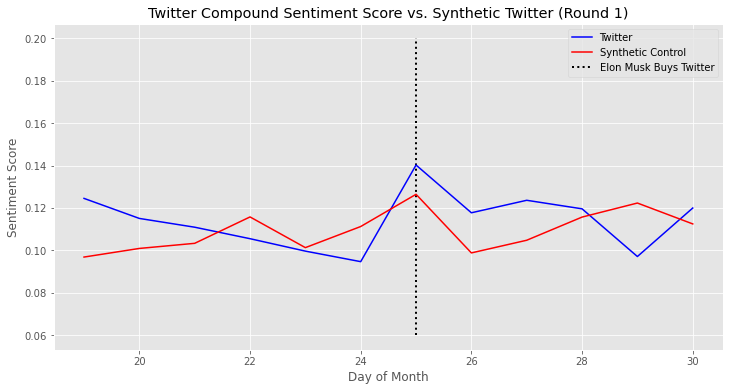

In [100]:
# Plot real vs. synthetic compound sentiment score
plt.figure(figsize=(12,6))
plt.plot(df3.query('Twitter')['Day'], df3.query('Twitter')['compound'], label='Twitter', color='blue')
plt.plot(df3.query('Twitter')['Day'], twitter_synth_lr, label='Synthetic Control', color='red')
plt.vlines(x=25, ymin=.06, ymax=.2, linestyle=':', lw=2, label='Elon Musk Buys Twitter', color='black')
plt.ylabel('Sentiment Score')
plt.xlabel('Day of Month')
plt.title('Twitter Compound Sentiment Score vs. Synthetic Twitter (Round 1)')
plt.legend();

Still not a very good representation where we can see the impact of the purchase on sentiment. Need to recalculate weights.

## Synthetic Control for Compound Sentiment Score (Round 2)
- Weights calculated differently (without extrapolation) using functions below

In [101]:
# From Causal Inference for The Brave and True (Matheus Facure Alves)
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [102]:
# From Causal Inference for The Brave and True (Matheus Facure Alves)
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [103]:
# Recalculate weights using function above
Twitter_weights = get_w(X, y)
print("Sum:", Twitter_weights.sum())
np.round(Twitter_weights, 4)

Sum: 1.0


array([0.2176, 0.    , 0.1798, 0.    , 0.6026])

In [104]:
# Add weights to new df
keywords = ['Facebook', 'Instagram', 'LinkedIn', 'Snapchat', 'Reddit']
weights = pd.DataFrame()
weights['Company'] = keywords
weights['Weight'] = np.round(Twitter_weights, 4)
weights

,Company,Weight
0,Facebook,0.2176
1,Instagram,0.0000
2,LinkedIn,0.1798
3,Snapchat,0.0000
4,Reddit,0.6026


In [105]:
# Creating second Synthetic Twitter for compound score by dotting weights with data
twitter_synth = df3.query("company != 'Twitter'").pivot(index='Day',
                                                        columns='company')['compound'].values.dot(Twitter_weights)

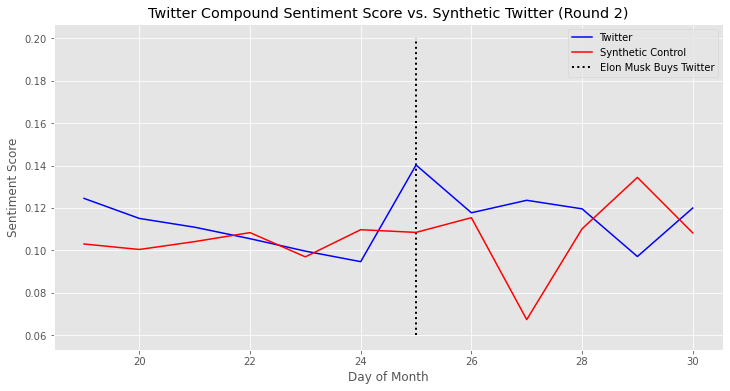

In [106]:
# Plot real vs. synthetic compound sentiment score
plt.figure(figsize=(12,6))
plt.plot(df3.query('Twitter')['Day'], df3.query('Twitter')['compound'], label='Twitter', color='blue')
plt.plot(df3.query('Twitter')['Day'], twitter_synth, label='Synthetic Control', color='red')
plt.vlines(x=25, ymin=.06, ymax=.2, linestyle=":", lw=2, label='Elon Musk Buys Twitter', color='black')
plt.ylabel('Sentiment Score')
plt.title('Twitter Compound Sentiment Score vs. Synthetic Twitter (Round 2)')
plt.xlabel('Day of Month')
plt.legend();

### Conclusions from Sentiment Score Synthetic Control
- Overall, tweet sentiment scores from other companies did not provide us with a great Synthetic Twitter Sentiment.
- Since sentiment is a calculated value itself, it is more difficult to make a Synthetic representation of it.
- More control groups or more tweets may have helped create a more accurate representation.
- The second round of Synthetic Control shows some divergence after the purchase, which is what we are looking for, but it does not allow us to clearly see the effect of the purchase on sentiment.
- Now time to try stock price.

## Synthetic Control for Stock Price
- Not all companies used prior are publicly traded, so new companies had to be chosen to make up the Synthetic Twitter stock price.
- The actual Twitter stock price will be plotted against the weighted combination of Facebook, Snapchat, and Pinterest.

In [107]:
tickers = {'Twitter':'TWTR', 'Facebook':'FB', 'Snapchat':'SNAP', 'Pinterest':'PINS'}

In [108]:
# obtaining stock history from 4/19/22 - 4/29/22.
import yfinance as yf

stocks = pd.DataFrame()
for company, ticker in tickers.items():
    stock = yf.Ticker(ticker)

    # get historical market data
    hist = stock.history(start='2022-04-19', end='2022-04-30')
    hist['Day'] = [19, 20, 21, 22, 25, 26, 27, 28, 29]
    hist['company'] = company
    stocks = pd.concat([stocks, hist])

In [109]:
# Assigning a boolean column for Twitter or not
stocks['Twitter'] = np.where(stocks['company'] == 'Twitter', True, False)
stocks

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day,company,Twitter
Date,,,,,,,,,,
2022-04-19,47.299999,48.500000,45.000000,46.160000,125776000,0,0,19,Twitter,True
2022-04-20,46.340000,47.110001,45.029999,46.720001,63360000,0,0,20,Twitter,True
2022-04-21,45.509998,47.939999,45.500000,47.080002,70413600,0,0,21,Twitter,True
2022-04-22,47.770000,49.730000,47.490002,48.930000,76504500,0,0,22,Twitter,True
2022-04-25,51.020000,52.290001,50.240002,51.700001,176803600,0,0,25,Twitter,True
2022-04-26,51.570000,51.619999,49.430000,49.680000,115020400,0,0,26,Twitter,True
2022-04-27,49.060001,49.259998,47.820000,48.639999,59106900,0,0,27,Twitter,True
2022-04-28,49.009998,49.919998,47.959999,49.110001,43816900,0,0,28,Twitter,True
2022-04-29,49.450001,50.250000,48.740002,49.020000,38198200,0,0,29,Twitter,True


In [110]:
# Create transposed dataframe with column for each compnay
features = ['High', 'Low', 'Close']

inverted = (stocks.query('Day < 25') # filter pre-intervention period
            .pivot(index='company', columns='Day')[features] # make one column per day and one row per company
            .T) # flip the table to have one column per company

inverted

company      Facebook  Pinterest   Snapchat    Twitter
      Day                                             
High  19   218.429993  22.969999  34.240002  48.500000
      20   214.160004  22.389999  33.180000  47.110001
      21   202.970001  21.379999  31.750000  47.939999
      22   192.720001  20.469999  31.209999  49.730000
Low   19   209.000000  21.360001  32.320000  45.000000
      20   198.919998  21.030001  30.700001  45.029999
      21   185.580002  19.870001  28.754999  45.500000
      22   183.270004  19.469999  28.559999  47.490002
Close 19   217.309998  22.719999  33.630001  46.160000
      20   200.419998  21.040001  30.760000  46.720001
      21   188.070007  20.230000  29.420000  47.080002
      22   184.110001  19.590000  29.760000  48.930000

In [111]:
# Extract data for synthetic and real
y = inverted['Twitter'].values
X = inverted.drop(columns='Twitter').values

In [112]:
# Run Linear regression to calculate weights of each company
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-1.041,  7.439,  3.152])

In [113]:
# Construct dataframe with weights
new_keywords = ['Facebook', 'Pinterest', 'Snapchat']
weights = pd.DataFrame()
weights['Company'] = new_keywords
weights['Weight'] = weights_lr.round(3)
weights

,Company,Weight
0,Facebook,-1.041
1,Pinterest,7.439
2,Snapchat,3.152


In [114]:
# Creating Synthetic Twitter for stock price by dotting weights with data
twitter_synth_lr = (stocks.query("company != 'Twitter'").pivot(index='Day',
                                                            columns='company')['Close'].values.dot(weights_lr))

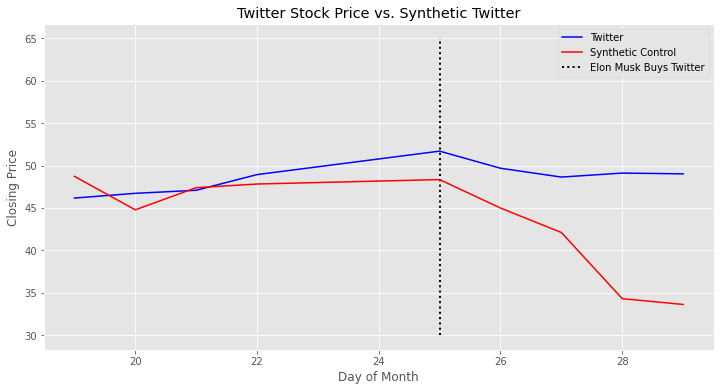

In [115]:
# Plot real vs. synthetic stock price
plt.figure(figsize=(12,6))
plt.plot(stocks.query('Twitter')['Day'], stocks.query('Twitter')['Close'], label='Twitter', color='blue')
plt.plot(stocks.query('Twitter')['Day'], twitter_synth_lr, label='Synthetic Control', color='red')
plt.vlines(x=25, ymin=30, ymax=65, linestyle=':', lw=2, label='Elon Musk Buys Twitter', color='black')
plt.ylabel('Closing Price')
plt.xlabel('Day of Month')
plt.title('Twitter Stock Price vs. Synthetic Twitter')
plt.legend();
# Best representation of the impact of Elon Musk purchase

Here were can clearly see the impact of the purchase. The real Twitter and the Synthetic follow closely before the purchase, and the real stock stayed fairly level after purchase, while the Synthetic forecasts that it would have dropped significantly if Musk did not buy it. 

On April 29, Twitter’s stock price was around 49 dollars, and the Synthetic Twitter forecasts it to be 33 dollars, showing a 33% difference.

`Treatment Effect`: Elon Musk purchasing Twitter caused the stock price to increase 33% more than if he did not purchase it.

## Conclusions

- Applying Synthetic Control to Twitter’s Stock Price allowed us to see the treatment effect most clearly.
- Creating a Synthetic Sentiment score was not very reliable to see the impact of the purchase because sentiment scores are already calculated values and can be misleading and volatile at times.
- Overall, we see that Elon Musk purchasing Twitter had a positive impact on the stock price.